In [1]:
import numpy as np

from os import listdir
from os.path import isdir, isfile, join

from kspon_jamo import text_to_tokens, tokens_to_text, n_symbols, normalize_ksponspeech, SOS, EOS

### Data file 리스트 만들기

In [2]:
data_dir = 'dataset'
data_files = [{'wav': join(data_dir, file),\
               'txt': join(data_dir, file[:-3] + 'txt')} for file in listdir(data_dir) if '.wav' in file]
print('# of data files :', len(data_files))
data_files.sort(key=lambda x:x['txt'])
for data_file in data_files[:10]:
    print(data_file)

# of data files : 1000
{'wav': 'dataset/KsponSpeech_000001.wav', 'txt': 'dataset/KsponSpeech_000001.txt'}
{'wav': 'dataset/KsponSpeech_000002.wav', 'txt': 'dataset/KsponSpeech_000002.txt'}
{'wav': 'dataset/KsponSpeech_000003.wav', 'txt': 'dataset/KsponSpeech_000003.txt'}
{'wav': 'dataset/KsponSpeech_000004.wav', 'txt': 'dataset/KsponSpeech_000004.txt'}
{'wav': 'dataset/KsponSpeech_000005.wav', 'txt': 'dataset/KsponSpeech_000005.txt'}
{'wav': 'dataset/KsponSpeech_000006.wav', 'txt': 'dataset/KsponSpeech_000006.txt'}
{'wav': 'dataset/KsponSpeech_000007.wav', 'txt': 'dataset/KsponSpeech_000007.txt'}
{'wav': 'dataset/KsponSpeech_000008.wav', 'txt': 'dataset/KsponSpeech_000008.txt'}
{'wav': 'dataset/KsponSpeech_000009.wav', 'txt': 'dataset/KsponSpeech_000009.txt'}
{'wav': 'dataset/KsponSpeech_000010.wav', 'txt': 'dataset/KsponSpeech_000010.txt'}


### txt 파일 보기

In [3]:
file = data_files[2]['txt']
with open(file, 'r', encoding='cp949') as f:
    l = f.read()
    print(l)

b/ n/ 그래서 지호랑 계단 n/ 올라와서 b/ 막 위에 운동하는 기구 있대요. b/ 그서 그걸로 운동 할려구요. b/ n/



### 텍스트 normalization하기

In [4]:
l = normalize_ksponspeech(l)
print(l)

그래서 지호랑 계단 올라와서 막 위에 운동하는 기구 있대요. 그서 그걸로 운동 할려구요.


### token으로 바꾸기

In [5]:
tokens = text_to_tokens(l)
print(tokens)

[257 295 256 260 297 256 263 289 256  32 265 296 256 270 291 256 260 287
 264 256  32 257 300 256 259 287 258 256  32 264 291 260 256 260 287 256
 264 301 256 263 289 256  32 261 287 257 256  32 264 306 256 264 299 256
  32 264 293 258 256 259 291 264 256 270 287 256 258 295 258 256  32 257
 296 256 257 293 256  32 264 296 274 256 259 297 256 264 292 256  46  32
 257 295 256 263 289 256  32 257 295 256 257 289 260 256 260 291 256  32
 264 293 258 256 259 291 264 256  32 270 287 260 256 260 290 256 257 293
 256 264 292 256  46]


### token을 텍스트로 바꾸기

In [6]:
text_recon = tokens_to_text(tokens)
print(text_recon)

그래서 지호랑 계단 올라와서 막 위에 운동하는 기구 있대요. 그서 그걸로 운동 할려구요.


### SOS, EOS 추가하기 (optional)

In [7]:
tokens = np.concatenate([[SOS], tokens, [EOS]])
print(tokens)

[308 257 295 256 260 297 256 263 289 256  32 265 296 256 270 291 256 260
 287 264 256  32 257 300 256 259 287 258 256  32 264 291 260 256 260 287
 256 264 301 256 263 289 256  32 261 287 257 256  32 264 306 256 264 299
 256  32 264 293 258 256 259 291 264 256 270 287 256 258 295 258 256  32
 257 296 256 257 293 256  32 264 296 274 256 259 297 256 264 292 256  46
  32 257 295 256 263 289 256  32 257 295 256 257 289 260 256 260 291 256
  32 264 293 258 256 259 291 264 256  32 270 287 260 256 260 290 256 257
 293 256 264 292 256  46 309]


### Pytorch Dataset Class 만들기
dataset.py파일을 만들어 KSponSpeechDataset와 KSponSpeechDataCollate를 저장합니다.

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import librosa
import librosa.display
import matplotlib.pyplot as plt

In [9]:
class KSponSpeechDataset(torch.utils.data.Dataset):
    def __init__(self, data_dir):
        self.data_files = [{'wav': join(data_dir, file),\
                            'txt': join(data_dir, file[:-3] + 'txt')} for file in listdir(data_dir) if '.wav' in file]

    def _get_audio(self, file):
        # (time,)
        wav, _ = librosa.core.load(file, sr=16000, mono=True)
        # (512, time)
        S = librosa.feature.melspectrogram(wav, sr=16000, n_fft=1024, n_mels=80, hop_length=256, power=1.0)
        S = np.log10(S + 1e-5) 
        # (time, 512)
        return wav, S.T
            
    def _get_text(self, file):
        with open(file, 'r', encoding='cp949') as f:
            l = f.read()
            l = normalize_ksponspeech(l)
            array = text_to_tokens(l)
        # Insert SOS and EOS
        array = np.concatenate([[SOS], array, [EOS]])
        return array
        
    def __getitem__(self, index):
        while True:
            text = self._get_text(self.data_files[index]['txt'])
            if len(text) > 180:
                index = (index + 1) % self.__len__()
                continue

            wav, mel = self._get_audio(self.data_files[index]['wav'])    
            if len(mel) > 450:
                index = (index + 1) % self.__len__()
                continue
                
            break
        
        return torch.FloatTensor(wav), torch.FloatTensor(mel), torch.LongTensor(text)
        
    def __len__(self):
        return len(self.data_files)

In [10]:
class KSponSpeechDataCollate():
    def __call__(self, batch):
        wav_lengths = []
        mel_lengths = []
        text_lengths = []
        for wav, mel, text in batch:
            wav_lengths.append(len(wav))
            mel_lengths.append(len(mel))
            text_lengths.append(len(text))
            
        wav_max_length = max(wav_lengths)
        mel_max_length = max(mel_lengths)
        text_max_length = max(text_lengths)
        
        wav_padded = torch.FloatTensor(len(batch), wav_max_length)
        wav_padded.zero_()
        mel_padded = torch.FloatTensor(len(batch), mel_max_length, 80)
        mel_padded.fill_(-5)
        mel_lengths = torch.from_numpy(np.array(mel_lengths)).long()
        
        text_padded = torch.LongTensor(len(batch), text_max_length)
        text_padded.zero_()
        text_lengths = torch.from_numpy(np.array(text_lengths)).long()
        
        for i, (wav, mel, text) in enumerate(batch):
            wav_padded[i, :len(wav)] = wav
            mel_padded[i, :len(mel)] = mel
            text_padded[i, :len(text)] = text
            
        outputs = {'wav': wav_padded,
                   'mel': mel_padded,
                   'mel_lengths': mel_lengths,
                   'text': text_padded,
                   'text_lengths': text_lengths
                  }
        
        return outputs

### Transfer data in batch to GPU

In [11]:
def to_cuda(batch):
    batch['mel'] = batch['mel'].cuda()
    batch['mel_lengths'] = batch['mel_lengths'].cuda()
    batch['text'] = batch['text'].cuda()
    batch['text_lengths'] = batch['text_lengths'].cuda()
    
    return batch

### Dataset Init.

In [12]:
dataset = KSponSpeechDataset(data_dir='dataset')
train_loader = DataLoader(dataset, num_workers=8, shuffle=True, batch_size=64, collate_fn=KSponSpeechDataCollate())
print(train_loader)

### Get mel-spectrogram and tokens

In [13]:
for batch in train_loader:
    mel = batch['mel'].data.cpu().numpy()
    mel_lengths = batch['mel_lengths'].data.cpu().numpy()
    text = batch['text'].data.cpu().numpy()
    text_lengths = batch['text_lengths'].data.cpu().numpy()
    break

### Plot mel-spectrogram and tokens

(64, 442, 80)


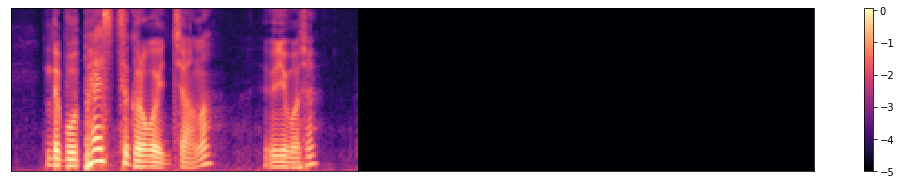

In [14]:
print(mel.shape)
plt.figure(figsize=[18, 3])
librosa.display.specshow(mel[0].T)
plt.colorbar()
plt.show()

In [15]:
print(mel_lengths.shape)
print(mel_lengths)

(64,)
[191 307  79 203 246 157 189 442 120  66 284 375 144 350 273 200 251 187
 169 348 393 232 297 211 134 311 287 105 110 307  74 400 391 382 387 258
 199 103 110 215 209 229 419 199 431 387 322  95 209  86 134 125 156 301
 171 120 322 113  92 105 350 204 259 331]


In [16]:
print(text.shape)
print(text[0])

(64, 153)
[308 257 295 258 256 259 299 256  32 261 304 256  32 269 297 256 263 295
 256 268 295 256  32 257 295 256 260 289 258 256  32 257 289 256  32 264
 296 274 256 265 296 256  32 264 287 278 256 264 287 256  63  32 264 294
 256 258 296 256 262 289 256 263 290 260 256  63 309   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]


In [17]:
print(text_lengths.shape)
print(text_lengths)

(64,)
[ 67  77  36  56  39  49  69 131  31   5  53 121  78 120  76  11  82  43
  50 105 153  46  83  69  15  91  92  36  33  99  23 110 100 113  92  86
  60  24  10  65  81  38  95  67  77 124  55  44  40  17  39  37  35  74
  33  38  55  40  13  26 117  50  43 115]
